In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#Understand the dataset
train.shape

(7613, 5)

In [4]:
#summary of the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Location columns contains more missing values, filling them will add bias to our model. We will ignore the column
Keyword will not be informative as we will be extracting tokens from main text column. Hence, keyword column is nothing but duplicate

In [5]:
#drop keyword, location columns from dataset
train= train.drop(['keyword', 'location'], axis=1)

In [6]:
# Find the number of positive and negative classes
train.target.value_counts()

train.target.value_counts() / len(train)

0    0.57034
1    0.42966
Name: target, dtype: float64

Target Label is imbalanced

#### WordCloud on Text

In [7]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

stopwords = set(STOPWORDS)

tweet_words= ''

# iterate through the csv file 
for val in train.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweet_words += " ".join(tokens)+" "

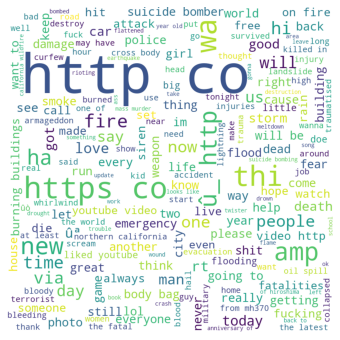

In [8]:
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(tweet_words) 
plt.imshow(wordcloud) 
plt.axis("off") 
  
plt.show() 

https, co are resultant of hyperlinks displayed bigger and bolder in wordcloud. These words cannot be part of vocabulary tokens

### Feature Creation

In [9]:
# Import the required packages from nltk
import nltk
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize

porter= PorterStemmer()
WNlemmatizer= WordNetLemmatizer()

# Transform the array of tweets to stemmed words
def stem_words(text):
    return " ".join([porter.stem(word) for word in text.split()])

train["text_stemmed"] = train["text"].apply(lambda text: stem_words(text))
train.head()

,id,text,target,text_stemmed
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deed are the reason of thi #earthquak may ...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near La rong sask. canada
2,5,All residents asked to 'shelter in place' are ...,1,all resid ask to 'shelter in place' are be not...
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 peopl receiv #wildfir evacu order in ca..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent thi photo from rubi #alaska as s...


In [10]:
# Transform the array of tweets to lemmatized words
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([WNlemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

train["text_lemmatized"] = train["text"].apply(lambda text: lemmatize_words(text))

train.head()

,id,text,target,text_stemmed,text_lemmatized
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deed are the reason of thi #earthquak may ...,Our Deeds be the Reason of this #earthquake Ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near La rong sask. canada,Forest fire near La Ronge Sask. Canada
2,5,All residents asked to 'shelter in place' are ...,1,all resid ask to 'shelter in place' are be not...,All resident ask to 'shelter in place' be be n...
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 peopl receiv #wildfir evacu order in ca...","13,000 people receive #wildfires evacuation or..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent thi photo from rubi #alaska as s...,Just get send this photo from Ruby #Alaska a s...


In [11]:
#seperate independent and outcome variable
X= train['text_lemmatized']
y= train['target']

In [12]:
# Import the necessary modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split


# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

In [13]:
# Define the stop words
my_stop_words = ENGLISH_STOP_WORDS.union(['https', 'co', 'http', '@', '_', '__', '#'])

In [14]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words=my_stop_words, ngram_range=(1, 2), min_df=10, token_pattern=r'\b[^\d\W][^\d\W]+\b' )

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

### Building a Logistic Regression classifier

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [16]:
logreg= LogisticRegression(solver='lbfgs')

logreg.fit(count_train, y_train)
y_predicted= logreg.predict(count_test)

# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_predicted))
print(confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on the test set:  0.7935924369747899
[[0.50052521 0.06985294]
 [0.13655462 0.29306723]]


In [17]:
#accuracy of training and test set
print("Training set accuracy is:", logreg.score(count_train, y_train))
print("Test set accuracy is:", logreg.score(count_test, y_test))

Training set accuracy is: 0.8546155193554037
Test set accuracy is: 0.7935924369747899


In [18]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1086
           1       0.81      0.68      0.74       818

    accuracy                           0.79      1904
   macro avg       0.80      0.78      0.78      1904
weighted avg       0.80      0.79      0.79      1904



Model underfits on Test set

We will Train our training and test set with Naive Bayes model

## Naive Bayes Model

In [19]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

MultinomialNB()

In [20]:
# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)

0.7815126050420168


In [21]:
#accuracy of training and test set
print("Training set accuracy is:", nb_classifier.score(count_train, y_train))
print("Test set accuracy is:", nb_classifier.score(count_test, y_test))

Training set accuracy is: 0.8078472587143107
Test set accuracy is: 0.7815126050420168


Though Model underfits on Test Set. The difference is less compared to LogisticRegression model

### Predict the test Dataset

In [22]:
#import and read test dataset
test = pd.read_csv('../input/nlp-getting-started/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Notice we dont have Target Label which we need to predict based on our Trained Logistic Regression model

Makesure to repeat similar transformation we did in Train Dataset

In [23]:
test= test.drop(['keyword', 'location'], axis=1)

In [24]:
test["text_lemmatized"] = test["text"].apply(lambda text: lemmatize_words(text))

In [25]:
test_vectorizer = count_vectorizer.transform(test['text_lemmatized'])

In [26]:
#predict the target label for test set
test_predictions = logreg.predict(test_vectorizer)
test_predictions

array([1, 1, 1, ..., 1, 1, 0])

In [27]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = test_predictions

In [28]:
submission.to_csv("submission.csv", index=False)

submission.tail()

,id,target
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
3262,10875,0


This is my baseline model and it is not better model either.

Needs to re-evaulate the model performance and come up with better Text Preprocessing. Notebook will be updated subsequently